**Zindi Africa - Crop Disease (Without optimization)**

In [ ]:
#hide
!fusermount -u drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')

fusermount: failed to unmount /content/drive: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found
Mounted at /content/drive


In [ ]:
!pip install torch
!pip install pytorch
!pip install torchvision
!pip install fastai
!pip3 install git+https://github.com/fastai/fastai.git 
!pip install -Uqq fastbook

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-5yfqmbl8/pytorch/setup.py'"'"'; __file__='"'"'/tmp/pip-install-5yfqmbl8/pytorch/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-9neknvec/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-rkpu0wze
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-rkpu0wze
     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 12.8MB 251kB/s 
     |████████████

In [ ]:
#hide
import PIL
from PIL import Image 
import os
import requests
import torch
import pandas as pd
from fastbook import *
from fastai.vision.widgets import *
fastbook.setup_book()

In [ ]:
path = Path('/content/gdrive/MyDrive/ColabNotebooks/CropDisease/train')
def get_y(r): return L(parent_label(r))

In [ ]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), get_items = get_image_files, get_y = get_y, item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(path)

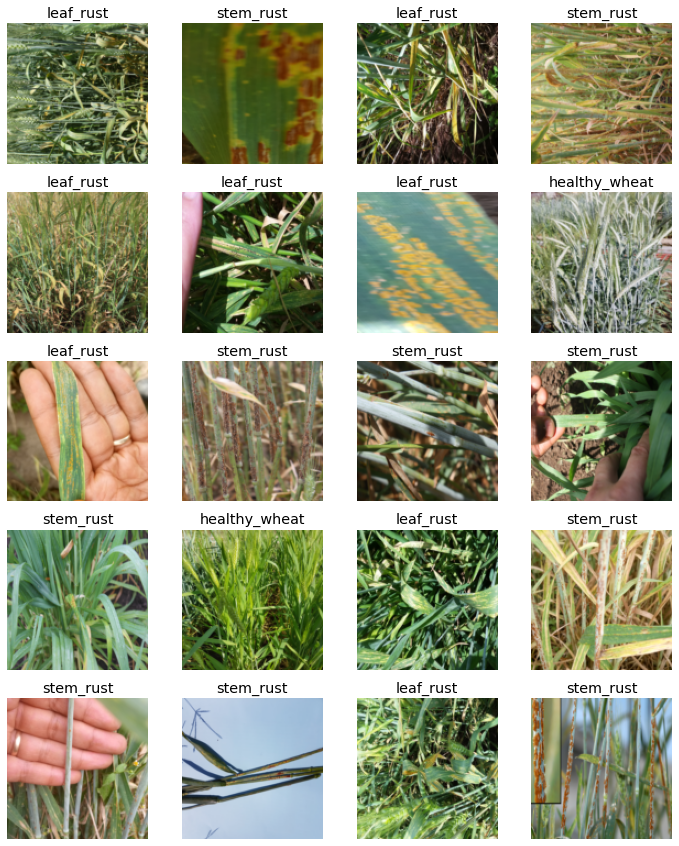

In [ ]:
dls.valid.show_batch(max_n=20, nrows=5)

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 3])

In [ ]:
activs[0]

tensor([ 3.8030, -1.6135, -1.2451], grad_fn=<SelectBackward>)

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.1572, grad_fn=<AliasBackward>)

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.986897,0.617047,0.467262,06:29
1,0.866881,0.836255,0.434524,01:39
2,0.773805,0.767243,0.470238,01:38
3,0.705984,0.837690,0.455357,01:41


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.419045,0.879703,0.497024,01:40
1,0.379041,0.891561,0.461309,01:39
2,0.334548,0.830140,0.479167,01:39


In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.8301404118537903,0.4285714328289032]

In [ ]:
preds,targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.6607)

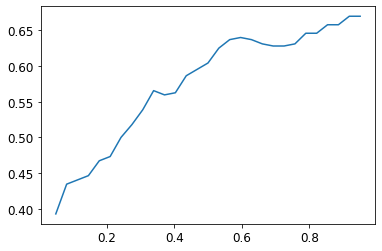

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
test_path = '/content/gdrive/MyDrive/ColabNotebooks/CropDisease/test/'

In [ ]:
def get_y(r): return L(parent_label(r))
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock), get_items = get_image_files, get_y = get_y, item_tfms=RandomResizedCrop(128, min_scale=0.35))
test_dls = dblock.dataloaders(Path(test_path))


In [ ]:
preds = []
for f in list(Path(test_path).iterdir())[:10]:
  file_path = Path(f)
  prediction,predictionIndex,props = learn.predict(f)
  preds.append(props)

  file_name = f
  

preds

[tensor([0.6452, 0.2063, 0.1264]),
 tensor([0.0164, 0.4432, 0.7683]),
 tensor([0.2779, 0.1468, 0.8119]),
 tensor([0.2053, 0.1380, 0.7563]),
 tensor([0.7717, 0.1169, 0.0277]),
 tensor([0.4008, 0.1284, 0.0804]),
 tensor([0.1458, 0.5369, 0.3677]),
 tensor([0.5934, 0.9857, 0.0026]),
 tensor([0.2113, 0.3282, 0.2828]),
 tensor([0.8431, 0.1915, 0.0118])]

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.7))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.988854,0.715089,0.642857,01:39
1,0.927798,0.641900,0.717262,01:40
2,0.853585,1.018824,0.482143,01:37
3,0.787563,0.619904,0.702381,01:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.561126,0.962537,0.491071,01:38
1,0.492276,0.708481,0.678571,01:39
2,0.425803,0.710064,0.669643,01:38


In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.7100639343261719,0.380952388048172]

In [ ]:
preds,targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.6667)

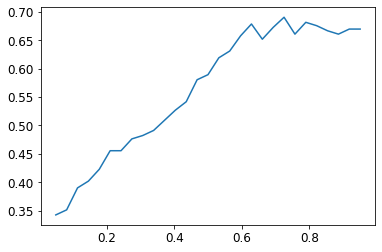

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [ ]:
preds = []
for f in list(Path(test_path).iterdir()):
  file_path = Path(f)
  prediction,predictionIndex,props = learn.predict(file_path)
  file_name = f
  predictions = f.stem,float(props[0]),float(props[1]),float(props[2])
  preds.append(predictions)
  

preds

[('0GJFRQ', 0.4072592854499817, 0.2115064263343811, 0.5767456293106079),
 ('01OJZX', 0.5468540191650391, 0.2660418152809143, 0.3389742374420166),
 ('00AQXY', 0.48992490768432617, 0.03328955918550491, 0.8804430961608887),
 ('08WLJO', 0.8353952169418335, 0.107103630900383, 0.4781472682952881),
 ('085IEC', 0.8033314347267151, 0.09795712679624557, 0.39156374335289),
 ('07OXKK', 0.45186296105384827, 0.09349234402179718, 0.5151895880699158),
 ('0J3PQ7', 0.7144035696983337, 0.24455933272838593, 0.2862822115421295),
 ('0K9T9T', 0.6431267261505127, 0.36270394921302795, 0.14193609356880188),
 ('0JIX2C', 0.17163488268852234, 0.6838212013244629, 0.7874372601509094),
 ('0E1VTP', 0.6430211663246155, 0.5702050924301147, 0.16290128231048584),
 ('008FWT', 0.5468540191650391, 0.2660418152809143, 0.3389742374420166),
 ('08O2YE', 0.6666571497917175, 0.06407009065151215, 0.5766940116882324),
 ('1BBY5N', 0.7042202353477478, 0.8663783669471741, 0.013487003743648529),
 ('0KUZ3P', 0.9619829654693604, 0.1738349

In [ ]:
dataFrame = pd.DataFrame(preds, columns=["ID","leaf_rust","stem_rust","healthy_wheat"])
dataFrame.to_csv('/content/gdrive/MyDrive/ColabNotebooks/CropDisease/results.csv', index=False)